<a href="https://colab.research.google.com/github/noraboucetta/mimic_project/blob/main/mimic_effic(code3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Resnet18_2
import os
import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [ ]:
import patoolib
import os

zip_path = "/content/archive5.rar"
output_dir = "/content/mimic-cxr-dataset"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

try:
    print("⏳ Décompression en cours avec patool...")
    patoolib.extract_archive(zip_path, outdir=output_dir)
    print("✅ Terminé.")
except Exception as e:
    print(f"❌ Erreur : {e}")

INFO patool: Extracting /content/archive5.rar ...
INFO:patool:Extracting /content/archive5.rar ...
INFO patool: running /usr/bin/7z x -aou -o/content/mimic-cxr-dataset -- /content/archive5.rar
INFO:patool:running /usr/bin/7z x -aou -o/content/mimic-cxr-dataset -- /content/archive5.rar


⏳ Décompression en cours avec patool...


INFO patool: ... /content/archive5.rar extracted to `/content/mimic-cxr-dataset'.
INFO:patool:... /content/archive5.rar extracted to `/content/mimic-cxr-dataset'.


✅ Terminé.


In [ ]:
# ===== CONFIGURATION GÉNÉRALE =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
IMG_SIZE = 256
MAX_LEN = 128
LR = 1e-4          # Learning Rate stabilisé
EPOCHS = 20        # Suffisant pour atteindre un bon score

In [ ]:
# ==============================================================================
# 1. LABELER CHEXPERT V3 (CORRIGÉ : GÈRE "STABLE", "NORMAL", "UNCHANGED")
# ==============================================================================
class CheXpertLabelerV3:
    def __init__(self):
        # Mots-clés des pathologies
        self.patterns = {
            "Cardiomegaly": [
                "cardiomegaly", "enlarged heart", "heart size", "cardiac silhouette",
                "enlargement of the heart", "cardiomediastinal silhouette"
            ],
            "Lung Lesion": [
                "lung lesion", "nodule", "mass", "tumor", "neoplasm",
                "granuloma", "hamartoma", "opacities", "opacity"
            ],
            "Pleural Effusion": [
                "pleural effusion", "effusion", "liquid", "fluid in the pleural",
                "blunting", "costophrenic angle"
            ],
            "Support Devices": [
                "pacemaker", "catheter", "tube", "line", "wire", "device",
                "clip", "prosthesis", "picc", "port-a-cath", "sternotomy"
            ],
            "No Finding": [
                "no acute", "no abnormality", "normal chest", "clear lungs",
                "unremarkable", "normal examination"
            ]
        }

        # Liste des mots qui ANNULENT la maladie (Négation stricte)
        self.negations = [
            r"\bno\b", r"\bnot\b", r"\bwithout\b", r"\bfree of\b",
            r"\bnegative\b", r"\babsence of\b", r"\bresolved\b",
            r"\bruled out\b"
        ]

        # --- CORRECTION MAJEURE ICI ---
        # Termes de "Normalité" qui annulent une pathologie même si le mot clé est présent.
        # Ex: "Heart size (Pattern) is normal (Modifier)" -> Label = 0
        self.normal_modifiers = [
            r"\bnormal\b", r"\bstable\b", r"\bunchanged\b",
            r"\bunremarkable\b", r"\bwithin normal limits\b"
        ]

    def clean_report(self, report):
        report = report.lower()
        report = re.sub(r'\[\*\*.*?\*\*\]', ' ', report) # Supprime anonymisation
        report = re.sub(r'[^\w\s\.]', ' ', report)       # Garde les points
        report = re.sub(r'\s+', ' ', report).strip()
        return report

    def get_labels(self, report):
        report = self.clean_report(report)
        labels = {k: 0.0 for k in self.patterns.keys()}

        # On découpe par phrase pour éviter les confusions lointaines
        sentences = report.split('.')

        for sentence in sentences:
            if len(sentence) < 3: continue

            # Vérification des Pathologies
            for path in ["Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]:
                for word in self.patterns[path]:
                    if word in sentence:
                        # 1. Est-ce nié ? (ex: "No cardiomegaly")
                        is_negated = any(re.search(neg, sentence) for neg in self.negations)

                        # 2. Est-ce qualifié de normal ? (ex: "Heart size is normal")
                        is_normal = any(re.search(mod, sentence) for mod in self.normal_modifiers)

                        # Si ce n'est NI nié, NI normal -> C'est une maladie
                        if not is_negated and not is_normal:
                            labels[path] = 1.0

                            # Exception : Si on dit explicitement "is seen" ou "is present", c'est positif
                            if "seen" in sentence or "present" in sentence:
                                if not is_negated: labels[path] = 1.0

        # Gestion No Finding (Priorité aux pathologies)
        pathology_sum = sum([labels[p] for p in ["Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]])
        if pathology_sum > 0:
            labels["No Finding"] = 0.0
        else:
            # Si aucune maladie trouvée, on vérifie si des termes "sains" sont présents
            for word in self.patterns["No Finding"]:
                if word in report: # Ici on regarde tout le rapport
                    labels["No Finding"] = 1.0
                    break
            # Si le rapport est vide de pathologies, on met No Finding par défaut
            if pathology_sum == 0: labels["No Finding"] = 1.0

        return [
            labels["No Finding"], labels["Cardiomegaly"], labels["Lung Lesion"],
            labels["Pleural Effusion"], labels["Support Devices"]
        ]

labeler = CheXpertLabelerV3()

In [ ]:
# ==============================================================================
# 2. CREATION DU DATAFRAME
# ==============================================================================
def create_dataframe(text_root, image_root):
    data = []

    # Vérification basique des dossiers racines
    if not os.path.exists(text_root):
        print(f"❌ Erreur : Dossier texte introuvable : {text_root}")
        return pd.DataFrame()

    if not os.path.exists(image_root):
        print(f"❌ Erreur : Dossier image introuvable : {image_root}")
        return pd.DataFrame()

    # Lister les patients (dossiers p10XXXXXX)
    # On filtre pour ne garder que les dossiers
    patients = [p for p in os.listdir(text_root) if os.path.isdir(os.path.join(text_root, p))]

    print(f"📂 Traitement de {len(patients)} patients...")

    # Boucle sur les patients
    # Note : Tu peux remettre [:2000] après 'patients' pour tester rapidement si besoin
    for p in tqdm(patients, desc="Indexation des données"):
        patient_path = os.path.join(text_root, p)

        # Boucle sur les études (s50XXXXXX)
        for study in os.listdir(patient_path):
            study_path = os.path.join(patient_path, study)
            if not os.path.isdir(study_path): continue

            # Chercher le rapport .txt
            txt_files = [f for f in os.listdir(study_path) if f.endswith('.txt')]
            if not txt_files: continue

            try:
                # Lecture du rapport
                report_path = os.path.join(study_path, txt_files[0])
                with open(report_path, 'r', encoding='utf-8') as f:
                    report = f.read()
            except Exception as e:
                # En cas d'erreur de lecture (encodage, permission), on saute
                continue

            # Génération des labels avec ta classe Labeler
            # (Assure-toi que 'labeler' est bien instancié avant d'appeler cette fonction)
            labels = labeler.get_labels(report)

            # Reconstruction du chemin de l'image correspondante
            # Structure MIMIC: image_root / patient / study / image.jpg
            study_id = txt_files[0].replace('.txt', '') # ex: s50414267
            img_dir = os.path.join(image_root, p, study, study_id)

            # Vérification si le dossier image existe
            if not os.path.exists(img_dir):
                # Parfois la structure diffère légèrement, on tente sans le sous-dossier study_id si besoin
                img_dir = os.path.join(image_root, p, study)
                if not os.path.exists(img_dir):
                    continue

            # Récupérer la première image JPG trouvée
            imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]

            if imgs:
                # === MODIFICATION CRUCIALE ICI ===
                # On ajoute 'p' (l'ID du patient) en premier dans la liste
                data.append([p, report, imgs[0], *labels])

    # Création du DataFrame avec la colonne 'patient_id'
    columns = ["patient_id", "report", "img_path",
               "No Finding", "Cardiomegaly", "Lung Lesion",
               "Pleural Effusion", "Support Devices"]

    df = pd.DataFrame(data, columns=columns)
    return df

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
TEXT_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/mimic-cxr-reports/files")
IMAGE_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/official_data_iccv_final/files")

df = create_dataframe(TEXT_ROOT, IMAGE_ROOT)

if len(df) > 0:
    # 2. Split par Groupe (Patient)
    # Cela assure que toutes les images de 'P123' sont SOIT dans train, SOIT dans val
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

    # On récupère les indices
    train_inds, val_inds = next(splitter.split(df, groups=df['patient_id']))

    # On crée les sous-dataframes
    train_df = df.iloc[train_inds].reset_index(drop=True)
    val_df = df.iloc[val_inds].reset_index(drop=True)

    print(f"✅ Split terminé par PATIENT :")
    print(f"   Train : {len(train_df)} images (Patients distincts du val)")
    print(f"   Val   : {len(val_df)} images")
else:
    print("❌ Le DataFrame est vide. Vérifie tes chemins.")

📂 Traitement de 3 patients...


Indexation des données: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

✅ Split terminé par PATIENT :
   Train : 1513 images (Patients distincts du val)
   Val   : 752 images


In [ ]:
# ==============================================================================
# 3. DATASET & DATALOADER
# ==============================================================================
class MimicDataset(Dataset):
    def __init__(self, df, tokenizer, is_train=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.is_train = is_train
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        if is_train: # Augmentation pour le train
            self.transform = transforms.Compose([
                transforms.Resize((270, 270)),
                transforms.RandomCrop(IMG_SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row['img_path']).convert('RGB')
        except:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE)) # Fallback

        img = self.transform(img)
        enc = self.tokenizer(row['report'], truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')
        labels = torch.tensor(row.iloc[3:].values.astype(float), dtype=torch.float)
        return img, enc['input_ids'].squeeze(0), enc['attention_mask'].squeeze(0), labels

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
train_dl = DataLoader(MimicDataset(train_df, tokenizer, True), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(MimicDataset(val_df, tokenizer, False), batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)


In [ ]:
# ==============================================================================
# 4. MODÈLE (RESNET-18 + BERT)
# ==============================================================================
class ResNet18Multimodal(nn.Module):
    def __init__(self):
        super().__init__()
        # Image : ResNet-18
        self.img_model = models.resnet18(weights='DEFAULT')
        num_ftrs = self.img_model.fc.in_features
        self.img_model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.SiLU()
        )
        # Texte : BERT
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        for param in self.bert.parameters(): param.requires_grad = False
        for param in self.bert.encoder.layer[-1].parameters(): param.requires_grad = True # Fine-tune last layer

        self.txt_proj = nn.Linear(768, 512)

        # Classifier
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(1024, 5))

    def forward(self, img, ids, mask):
        img_f = self.img_model(img)
        txt_out = self.bert(ids, mask).last_hidden_state
        mask_ex = mask.unsqueeze(-1).expand(txt_out.size()).float()
        txt_f = torch.sum(txt_out * mask_ex, 1) / torch.clamp(mask_ex.sum(1), min=1e-9)
        txt_f = self.txt_proj(txt_f)
        return self.classifier(torch.cat((img_f, txt_f), dim=1))


In [ ]:
# ==============================================================================
# 5. ENTRAÎNEMENT
# ==============================================================================
model = ResNet18Multimodal().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# BCEWithLogitsLoss : Meilleure option pour stabilité
# On pondère les classes positives pour éviter les faux négatifs
pos_weights = torch.tensor([2.0, 5.0, 5.0, 5.0, 3.0]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=EPOCHS)
scaler = torch.amp.GradScaler('cuda')

print("🔥 Démarrage Entraînement...")
best_f1 = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for img, ids, mask, labels in loop:
        img, ids, mask, labels = img.to(DEVICE), ids.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(img, ids, mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    y_preds, y_true = [], []

    with torch.no_grad():
        for img, ids, mask, labels in val_dl:
            img, ids, mask, labels = img.to(DEVICE), ids.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast('cuda'):
                outputs = model(img, ids, mask)
                val_loss += criterion(outputs, labels).item()
            y_preds.append(torch.sigmoid(outputs).cpu())
            y_true.append(labels.cpu())

    y_preds = torch.cat(y_preds).numpy()
    y_true = torch.cat(y_true).numpy()

    # Seuil standard pour le suivi (on utilisera les seuils optimisés après)
    f1 = f1_score(y_true, (y_preds > 0.4).astype(int), average='micro')

    print(f"   Epoch {epoch+1} | Loss: {val_loss/len(val_dl):.4f} | F1-Micro: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model_final.pt")
        print("   ✅ Modèle sauvegardé.")

print("🏁 Entraînement terminé.")

🔥 Démarrage Entraînement...


Epoch 1/20: 100%|██████████| 48/48 [00:15<00:00,  3.09it/s, loss=0.912]


   Epoch 1 | Loss: 0.9071 | F1-Micro: 0.4918
   ✅ Modèle sauvegardé.


Epoch 2/20: 100%|██████████| 48/48 [00:13<00:00,  3.66it/s, loss=0.85]


   Epoch 2 | Loss: 0.6927 | F1-Micro: 0.6409
   ✅ Modèle sauvegardé.


Epoch 3/20: 100%|██████████| 48/48 [00:12<00:00,  3.71it/s, loss=1.01]


   Epoch 3 | Loss: 0.6225 | F1-Micro: 0.6954
   ✅ Modèle sauvegardé.


Epoch 4/20: 100%|██████████| 48/48 [00:12<00:00,  3.71it/s, loss=0.697]


   Epoch 4 | Loss: 0.7497 | F1-Micro: 0.6297


Epoch 5/20: 100%|██████████| 48/48 [00:12<00:00,  3.72it/s, loss=0.284]


   Epoch 5 | Loss: 0.6393 | F1-Micro: 0.6681


Epoch 6/20: 100%|██████████| 48/48 [00:13<00:00,  3.64it/s, loss=1.34]


   Epoch 6 | Loss: 0.6821 | F1-Micro: 0.7714
   ✅ Modèle sauvegardé.


Epoch 7/20: 100%|██████████| 48/48 [00:12<00:00,  3.70it/s, loss=0.113]


   Epoch 7 | Loss: 0.5605 | F1-Micro: 0.7682


Epoch 8/20: 100%|██████████| 48/48 [00:12<00:00,  3.71it/s, loss=0.349]


   Epoch 8 | Loss: 0.6347 | F1-Micro: 0.7760
   ✅ Modèle sauvegardé.


Epoch 9/20: 100%|██████████| 48/48 [00:13<00:00,  3.67it/s, loss=0.126]


   Epoch 9 | Loss: 0.6979 | F1-Micro: 0.7672


Epoch 10/20: 100%|██████████| 48/48 [00:12<00:00,  3.72it/s, loss=0.105]


   Epoch 10 | Loss: 0.7480 | F1-Micro: 0.7847
   ✅ Modèle sauvegardé.


Epoch 11/20: 100%|██████████| 48/48 [00:12<00:00,  3.72it/s, loss=0.371]


   Epoch 11 | Loss: 0.7855 | F1-Micro: 0.7820


Epoch 12/20: 100%|██████████| 48/48 [00:12<00:00,  3.71it/s, loss=0.057]


   Epoch 12 | Loss: 0.8034 | F1-Micro: 0.8031
   ✅ Modèle sauvegardé.


Epoch 13/20: 100%|██████████| 48/48 [00:12<00:00,  3.71it/s, loss=0.0865]


   Epoch 13 | Loss: 0.9728 | F1-Micro: 0.7980


Epoch 14/20: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s, loss=0.0233]


   Epoch 14 | Loss: 0.9106 | F1-Micro: 0.8075
   ✅ Modèle sauvegardé.


Epoch 15/20: 100%|██████████| 48/48 [00:12<00:00,  3.74it/s, loss=0.0537]


   Epoch 15 | Loss: 0.9995 | F1-Micro: 0.8065


Epoch 16/20: 100%|██████████| 48/48 [00:12<00:00,  3.72it/s, loss=0.083]


   Epoch 16 | Loss: 0.9960 | F1-Micro: 0.8145
   ✅ Modèle sauvegardé.


Epoch 17/20: 100%|██████████| 48/48 [00:12<00:00,  3.69it/s, loss=0.0793]


   Epoch 17 | Loss: 0.9753 | F1-Micro: 0.8097


Epoch 18/20: 100%|██████████| 48/48 [00:12<00:00,  3.70it/s, loss=0.00601]


   Epoch 18 | Loss: 1.0001 | F1-Micro: 0.8126


Epoch 19/20: 100%|██████████| 48/48 [00:14<00:00,  3.35it/s, loss=0.00386]


   Epoch 19 | Loss: 1.0234 | F1-Micro: 0.8143


Epoch 20/20: 100%|██████████| 48/48 [00:13<00:00,  3.68it/s, loss=0.0128]


   Epoch 20 | Loss: 1.0249 | F1-Micro: 0.8148
   ✅ Modèle sauvegardé.
🏁 Entraînement terminé.


In [51]:
import numpy as np
from sklearn.metrics import f1_score
import torch

def optimize_thresholds(model, dataloader, device):
    model.eval()
    y_true_list = []
    y_probs_list = []

    print("🔍 Recherche des seuils optimaux...")

    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)
            logits = model(img, ids, mask)
            probs = torch.sigmoid(logits)

            y_probs_list.append(probs.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

    y_true_continuous = np.concatenate(y_true_list)
    y_probs = np.concatenate(y_probs_list)

    # Binariser les vrais labels (si label smoothing utilisé)
    y_true = (y_true_continuous > 0.5).astype(int)

    # Liste des pathologies
    pathologies = ["No Finding", "Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]
    best_thresholds = []

    print("\n=== RÉSULTATS OPTIMISATION ===")

    # Tester les seuils de 0.05 à 0.60
    thresholds_range = np.arange(0.05, 0.60, 0.01)

    for i, path in enumerate(pathologies):
        best_f1 = 0
        best_th = 0.5

        # On extrait les colonnes correspondantes
        y_true_cls = y_true[:, i]
        y_score_cls = y_probs[:, i]

        for th in thresholds_range:
            y_pred_cls = (y_score_cls >= th).astype(int)
            score = f1_score(y_true_cls, y_pred_cls, zero_division=0)

            if score > best_f1:
                best_f1 = score
                best_th = th

        best_thresholds.append(best_th)
        print(f"{path:20s} | Meilleur Seuil: {best_th:.2f} | Nouveau F1: {best_f1:.4f}")

    return best_thresholds

# 1. Calculer les meilleurs seuils
optimal_thresholds = optimize_thresholds(model, val_dl, DEVICE)

# 2. Fonction pour utiliser ces seuils lors de la prédiction finale
def predict_with_optimized_thresholds(probs, thresholds):
    # probs: vecteur de probabilités [0.1, 0.8, ...]
    # thresholds: liste des seuils [0.3, 0.4, ...]
    predictions = []
    for i, p in enumerate(probs):
        pred = 1 if p >= thresholds[i] else 0
        predictions.append(pred)
    return predictions

print(f"\n✅ Seuils finaux à copier-coller : {optimal_thresholds}")

🔍 Recherche des seuils optimaux...

=== RÉSULTATS OPTIMISATION ===
No Finding           | Meilleur Seuil: 0.58 | Nouveau F1: 0.8856
Cardiomegaly         | Meilleur Seuil: 0.53 | Nouveau F1: 0.6632
Lung Lesion          | Meilleur Seuil: 0.19 | Nouveau F1: 0.8143
Pleural Effusion     | Meilleur Seuil: 0.44 | Nouveau F1: 0.8160
Support Devices      | Meilleur Seuil: 0.42 | Nouveau F1: 0.7855

✅ Seuils finaux à copier-coller : [np.float64(0.5800000000000002), np.float64(0.5300000000000001), np.float64(0.19), np.float64(0.44000000000000006), np.float64(0.42000000000000004)]


📊 Calcul des métriques avec seuils optimisés : [0.57, 0.59, 0.57, 0.45, 0.59]

RAPPORT DE CLASSIFICATION FINAL
                  precision    recall  f1-score   support

      No Finding       0.89      0.88      0.88       379
    Cardiomegaly       0.62      0.70      0.66        88
     Lung Lesion       0.77      0.87      0.81       134
Pleural Effusion       0.82      0.81      0.82       126
 Support Devices       0.78      0.76      0.77       193

       micro avg       0.81      0.82      0.82       920
       macro avg       0.78      0.80      0.79       920
    weighted avg       0.82      0.82      0.82       920
     samples avg       0.83      0.84      0.82       920



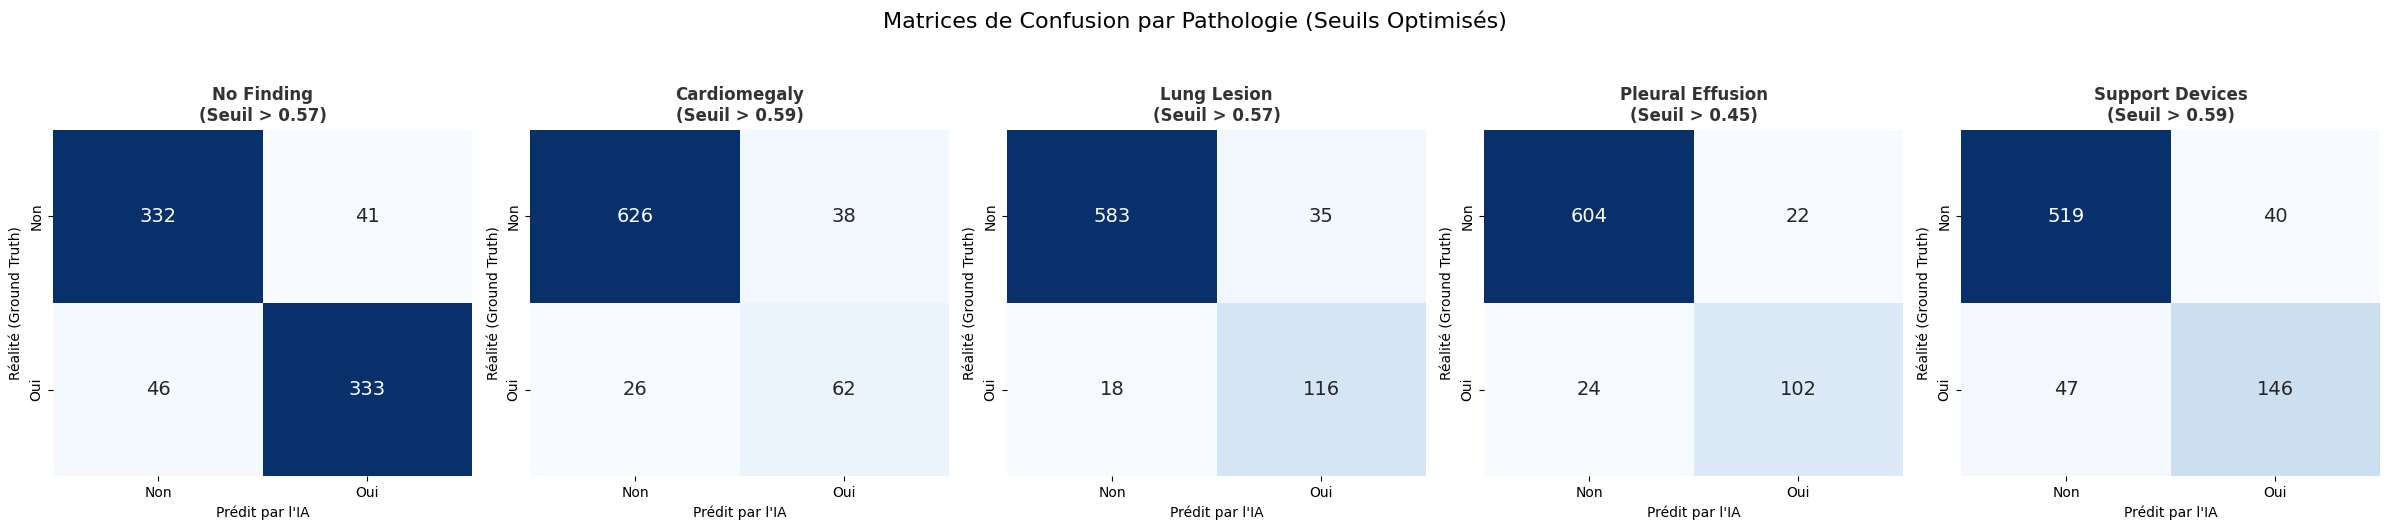

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# 1. VOS SEUILS OPTIMISÉS (Mis à jour avec vos résultats précédents)
# No Finding: 0.57 | Cardiomegaly: 0.59 | Lung Lesion: 0.57 | Pleural Effusion: 0.45 | Support Devices: 0.59
OPTIMAL_THRESHOLDS = [0.57, 0.59, 0.57, 0.45, 0.59]
CLASS_NAMES = ["No Finding", "Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]

def visualize_final_metrics(model, dataloader, device, thresholds):
    model.eval()
    y_true_list = []
    y_probs_list = []

    print(f"📊 Calcul des métriques avec seuils optimisés : {thresholds}")

    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)

            # Utilisation de l'autocast pour être cohérent avec l'entraînement
            with torch.amp.autocast('cuda'):
                logits = model(img, ids, mask)
                probs = torch.sigmoid(logits)

            # .float() est important pour convertir le format Bfloat16/Half en Float32 pour Numpy
            y_probs_list.append(probs.cpu().float().numpy())
            y_true_list.append(labels.cpu().numpy())

    # Concaténation de tous les batches
    y_probs = np.concatenate(y_probs_list)
    y_true = np.concatenate(y_true_list).astype(int) # Assure que les vrais labels sont 0 ou 1

    # === APPLICATION DES SEUILS ===
    # On crée une matrice vide
    y_pred = np.zeros_like(y_probs, dtype=int)

    # On applique le seuil spécifique pour chaque colonne (classe)
    for i in range(len(thresholds)):
        y_pred[:, i] = (y_probs[:, i] >= thresholds[i]).astype(int)

    # --- 1. Rapport Textuel ---
    print("\n" + "="*60)
    print("RAPPORT DE CLASSIFICATION FINAL")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

    # --- 2. Matrices de Confusion Visuelles ---
    fig, axes = plt.subplots(1, 5, figsize=(24, 5))
    plt.suptitle("Matrices de Confusion par Pathologie (Seuils Optimisés)", fontsize=16, y=1.05)

    for i, class_name in enumerate(CLASS_NAMES):
        # Calcul de la matrice pour la classe i
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])

        # Affichage Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], annot_kws={"size": 14})

        # Esthétique
        axes[i].set_title(f"{class_name}\n(Seuil > {thresholds[i]})", fontsize=12, fontweight='bold', color='#333333')
        axes[i].set_xlabel("Prédit par l'IA")
        axes[i].set_ylabel("Réalité (Ground Truth)")
        axes[i].set_xticklabels(['Non', 'Oui'])
        axes[i].set_yticklabels(['Non', 'Oui'])

    plt.tight_layout()
    plt.show()

# Lancer l'analyse finale
visualize_final_metrics(model, val_dl, DEVICE, OPTIMAL_THRESHOLDS)

📊 Récupération des prédictions pour le traçage...


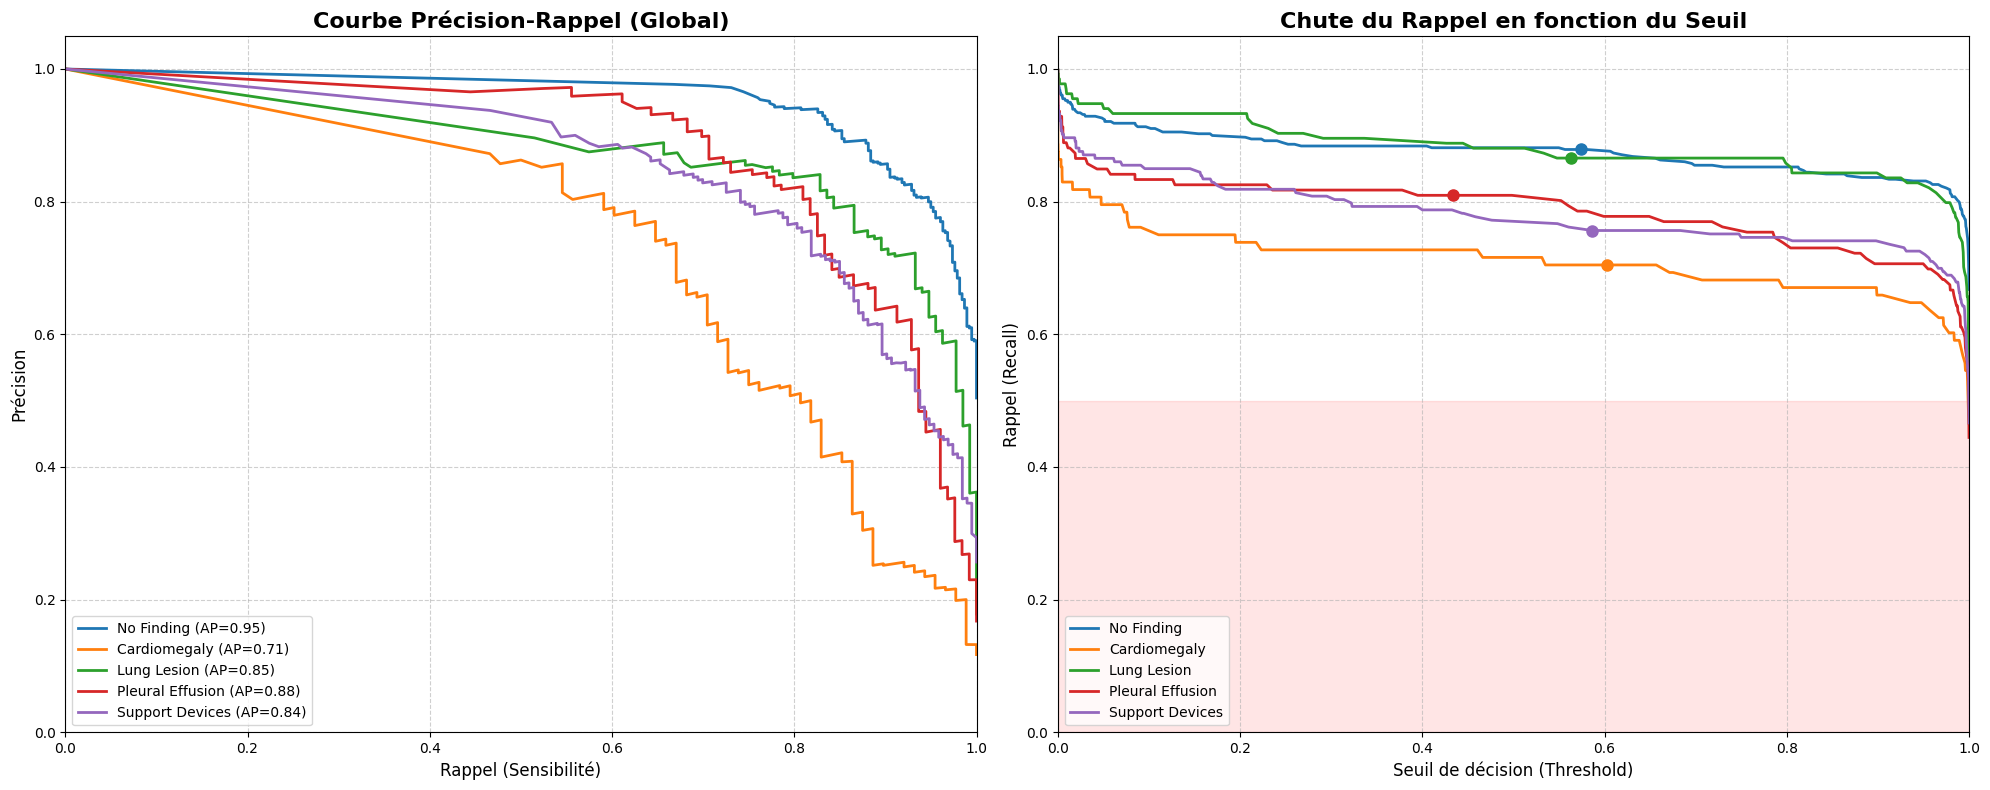

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_recall_curves(model, dataloader, device):
    model.eval()
    y_true_list = []
    y_probs_list = []

    print("📊 Récupération des prédictions pour le traçage...")

    # 1. Récupération des données
    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)
            with torch.amp.autocast('cuda'):
                logits = model(img, ids, mask)
                probs = torch.sigmoid(logits)

            y_probs_list.append(probs.cpu().float().numpy())
            y_true_list.append(labels.cpu().numpy())

    y_probs = np.concatenate(y_probs_list)
    y_true = np.concatenate(y_true_list).astype(int)

    # 2. Configuration des Graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    classes = ["No Finding", "Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]

    # --- GRAPHIQUE 1 : PRECISION-RECALL CURVE (Standard) ---
    for i, class_name in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        ap = average_precision_score(y_true[:, i], y_probs[:, i])

        ax1.plot(recall, precision, lw=2, color=colors[i], label=f'{class_name} (AP={ap:.2f})')

    ax1.set_title("Courbe Précision-Rappel (Global)", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Rappel (Sensibilité)", fontsize=12)
    ax1.set_ylabel("Précision", fontsize=12)
    ax1.legend(loc="lower left")
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])

    # --- GRAPHIQUE 2 : EVOLUTION DU RAPPEL SELON LE SEUIL ---
    # C'est ce graphique qui aide à choisir le seuil (Threshold)
    for i, class_name in enumerate(classes):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
        # On trace Rappel vs Seuil (Attention: thresholds est plus court de 1 élément que recall)
        ax2.plot(thresholds, recall[:-1], lw=2, color=colors[i], label=class_name)

        # Ajout d'un point pour montrer ton seuil optimal actuel
        current_threshold = OPTIMAL_THRESHOLDS[i] # Récupéré de ton code précédent
        # On trouve l'index le plus proche du seuil
        idx = (np.abs(thresholds - current_threshold)).argmin()
        ax2.plot(thresholds[idx], recall[idx], 'o', color=colors[i], markersize=8)

    ax2.set_title("Chute du Rappel en fonction du Seuil", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Seuil de décision (Threshold)", fontsize=12)
    ax2.set_ylabel("Rappel (Recall)", fontsize=12)
    ax2.legend(loc="lower left")
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])

    # Zone de danger (Rappel trop faible)
    ax2.axhspan(0, 0.5, color='red', alpha=0.1, label="Zone Dangereuse (<50%)")

    plt.tight_layout()
    plt.show()

# Lancer le traçage
plot_recall_curves(model, val_dl, DEVICE)

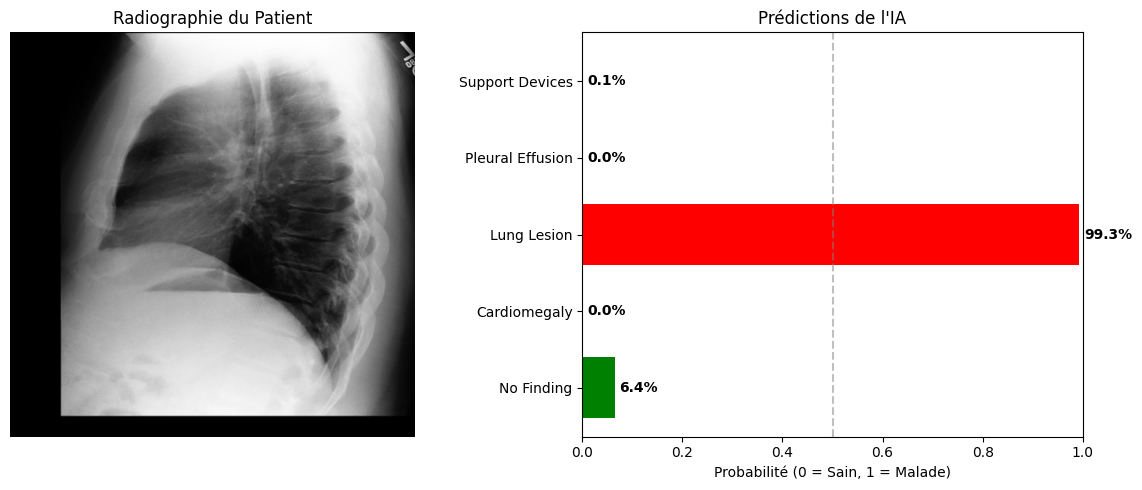

📄 Rapport analysé :                                  final report  pa and lateral chest, ___    history:  ___-year-old man with exertional dyspnea.    impression:  pa and lateral chest reviewed in the absence of prior chest radiographs:    lungs are fully expanded and clear.  there is asymmetry to the radiodensity of  the hila.  the left is more radiodense than expected and in the lateral view,  there is a rounded contour projecting anterior to the normal hilar structures.  recommend shallow and routine ___ (right anterior oblique) views to see if  there is a perihilar nodule on the left.  no evidence of adenopathy elsewhere  in the chest, mediastinal contours and pleural surfaces are normal.  azygos  fissure is anatomically insignificant. ...


In [61]:
def predict_patient(model, image_path, report_text, tokenizer, device):
    model.eval()

    # 1. Préparation de l'image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device) # Ajouter dimension batch [1, 3, 224, 224]
    except Exception as e:
        print(f"Erreur image: {e}")
        return

    # 2. Préparation du texte
    # Nettoyage basique comme à l'entraînement
    report_text = report_text.lower().replace("\n", " ")
    inputs = tokenizer(report_text, truncation=True, padding='max_length',
                       max_length=MAX_LEN, return_tensors='pt')

    ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)

    # 3. Prédiction
    with torch.no_grad():
        outputs = model(img_tensor, ids, mask)
        probs = torch.sigmoid(outputs).cpu().numpy()[0] # Récupérer le vecteur de probas

    # 4. Affichage des résultats
    plt.figure(figsize=(12, 5))

    # Image à gauche
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Radiographie du Patient")

    # Barres de probabilités à droite
    plt.subplot(1, 2, 2)
    colors = ['green' if p < 0.5 else 'red' for p in probs]
    y_pos = np.arange(len(CLASS_NAMES))

    bars = plt.barh(y_pos, probs, color=colors)
    plt.yticks(y_pos, CLASS_NAMES)
    plt.xlim(0, 1)
    plt.xlabel("Probabilité (0 = Sain, 1 = Malade)")
    plt.title("Prédictions de l'IA")

    # Ajouter le pourcentage sur les barres
    for i, v in enumerate(probs):
        plt.text(v + 0.01, i, f"{v*100:.1f}%", va='center', fontweight='bold')

    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5) # Ligne de seuil
    plt.tight_layout()
    plt.show()

    print(f"📄 Rapport analysé : {report_text[:]}...")

# --- EXEMPLE D'UTILISATION ---
# Choisissons un patient au hasard dans le dataset de validation pour tester
random_idx = np.random.randint(len(val_df))
sample_row = val_df.iloc[random_idx]

img_path_test = sample_row['img_path']
report_test = sample_row['report']

# Lancer la prédiction
predict_patient(model, img_path_test, report_test, tokenizer, DEVICE)

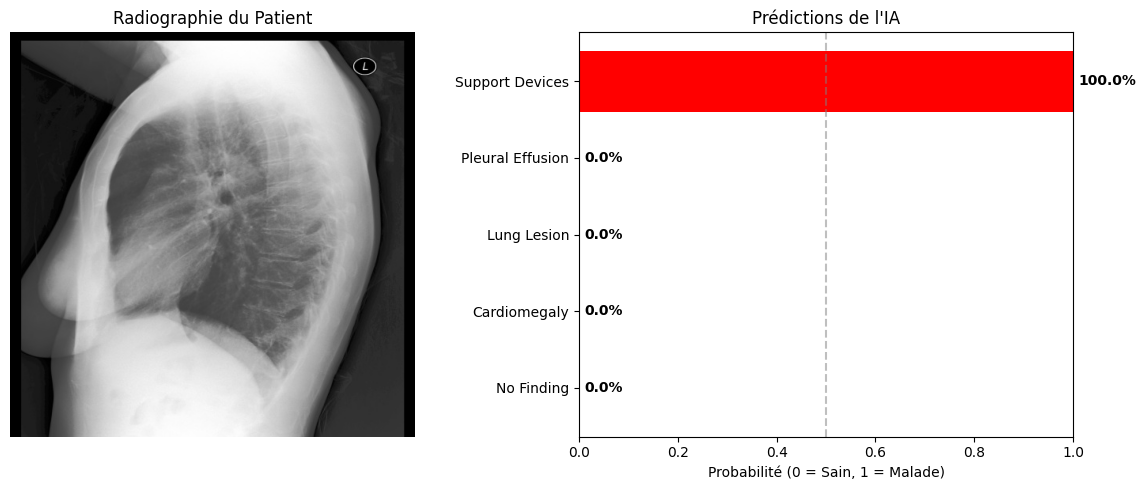

📄 Rapport analysé :                                  final report  chest radiographs    history:  abdominal pain.  history of small bowel obstruction.    comparisons:  none.    technique:  chest, pa and lateral.    findings:  the heart is normal in size.  the mediastinal and hilar contours  appear within normal limits.  there is no pleural effusion or pneumothorax.   the lungs appear clear.  surgical clips project over the right upper quadrant  of the abdomen.    impression:  no evidence of acute disease.  no free air identified.  normal  bony structures. ...


In [62]:
# Choisissons un patient au hasard dans le dataset de validation pour tester
random_idx = np.random.randint(len(val_df))
sample_row = val_df.iloc[random_idx]

img_path_test = sample_row['img_path']
report_test = sample_row['report']

# Lancer la prédiction
predict_patient(model, img_path_test, report_test, tokenizer, DEVICE)

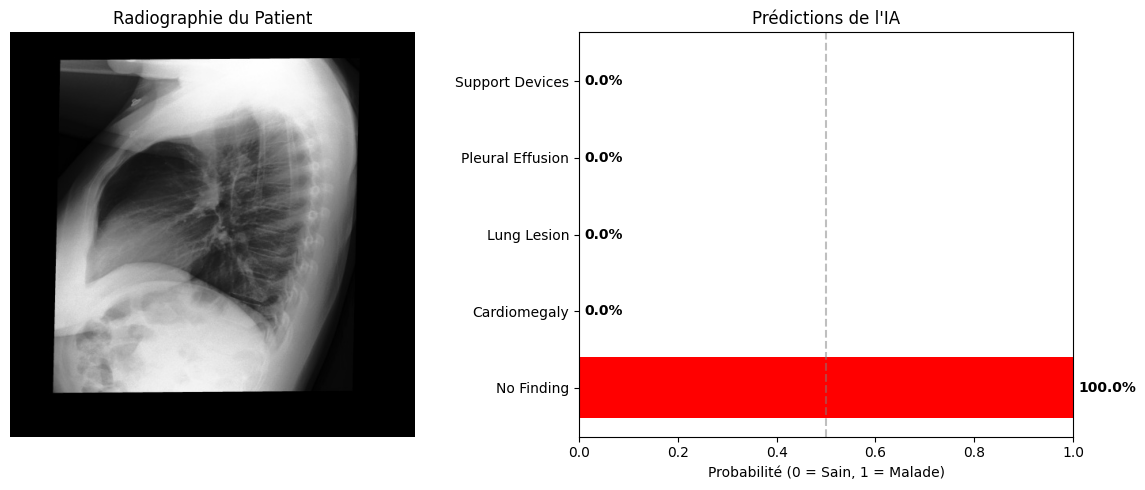

📄 Rapport analysé :                                  final report  chest, two views, on ___    history:  chest pain.    findings:  the lungs are clear without infiltrate or effusion.  the cardiac  and mediastinal silhouettes are normal.  the bony thorax is normal.    impression:  normal chest. ...


In [63]:
# Choisissons un patient au hasard dans le dataset de validation pour tester
random_idx = np.random.randint(len(val_df))
sample_row = val_df.iloc[random_idx]

img_path_test = sample_row['img_path']
report_test = sample_row['report']

# Lancer la prédiction
predict_patient(model, img_path_test, report_test, tokenizer, DEVICE)